<a href="https://colab.research.google.com/github/papaya147/predictive-analysis/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://ora.ox.ac.uk/objects/uuid:99d7c092-d865-4a19-b096-cc16440cd001/files/rpr76f381b

--2024-11-06 06:24:02--  https://ora.ox.ac.uk/objects/uuid:99d7c092-d865-4a19-b096-cc16440cd001/files/rpr76f381b
Resolving ora.ox.ac.uk (ora.ox.ac.uk)... 129.67.246.216
Connecting to ora.ox.ac.uk (ora.ox.ac.uk)|129.67.246.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘rpr76f381b’

rpr76f381b              [                <=> ]   6.43G  27.0MB/s    in 4m 11s  

2024-11-06 06:28:14 (26.3 MB/s) - ‘rpr76f381b’ saved [6902652480]



In [2]:
!unzip rpr76f381b -d data >> /dev/null

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
def extract_features(xyz, sample_rate=100):
    ''' Extract commonly used HAR time-series features. xyz is a window of shape (N,3) '''

    feats = {}

    x, y, z = xyz.T

    feats['xmin'], feats['xq25'], feats['xmed'], feats['xq75'], feats['xmax'] = np.quantile(
        x, (0, .25, .5, .75, 1))
    feats['ymin'], feats['yq25'], feats['ymed'], feats['yq75'], feats['ymax'] = np.quantile(
        y, (0, .25, .5, .75, 1))
    feats['zmin'], feats['zq25'], feats['zmed'], feats['zq75'], feats['zmax'] = np.quantile(
        z, (0, .25, .5, .75, 1))

    with np.errstate(divide='ignore', invalid='ignore'):  # ignore div by 0 warnings
        # xy, xy, zx correlation
        feats['xycorr'] = np.nan_to_num(np.corrcoef(x, y)[0, 1])
        feats['yzcorr'] = np.nan_to_num(np.corrcoef(y, z)[0, 1])
        feats['zxcorr'] = np.nan_to_num(np.corrcoef(z, x)[0, 1])

    v = np.linalg.norm(xyz, axis=1)

    feats['min'], feats['q25'], feats['med'], feats['q75'], feats['max'] = np.quantile(
        v, (0, .25, .5, .75, 1))

    with np.errstate(divide='ignore', invalid='ignore'):  # ignore div by 0 warnings
        # 1s autocorrelation
        feats['corr1s'] = np.nan_to_num(np.corrcoef(
            v[:-sample_rate], v[sample_rate:]))[0, 1]

    # Angular features
    feats.update(angular_features(xyz, sample_rate))

    # Spectral features
    feats.update(spectral_features(v, sample_rate))

    # Peak features
    feats.update(peak_features(v, sample_rate))

    return feats


def spectral_features(v, sample_rate):
    """ Spectral entropy, 1st & 2nd dominant frequencies """

    feats = {}

    # Spectrum using Welch's method with 3s segment length
    # First run without detrending to get the true spectrum
    freqs, powers = signal.welch(v, fs=sample_rate,
                                 nperseg=3 * sample_rate,
                                 noverlap=2 * sample_rate,
                                 detrend=False,
                                 average='median')

    with np.errstate(divide='ignore', invalid='ignore'):  # ignore div by 0 warnings
        feats['pentropy'] = np.nan_to_num(stats.entropy(powers + 1e-16))

    # Spectrum using Welch's method with 3s segment length
    # Now do detrend to focus on the relevant freqs
    freqs, powers = signal.welch(v, fs=sample_rate,
                                 nperseg=3 * sample_rate,
                                 noverlap=2 * sample_rate,
                                 detrend='constant',
                                 average='median')

    peaks, _ = signal.find_peaks(powers)
    peak_powers = powers[peaks]
    peak_freqs = freqs[peaks]
    peak_ranks = np.argsort(peak_powers)[::-1]
    if len(peaks) >= 2:
        feats['f1'] = peak_freqs[peak_ranks[0]]
        feats['f2'] = peak_freqs[peak_ranks[1]]
        feats['p1'] = peak_powers[peak_ranks[0]]
        feats['p2'] = peak_powers[peak_ranks[1]]
    elif len(peaks) == 1:
        feats['f1'] = feats['f2'] = peak_freqs[peak_ranks[0]]
        feats['p1'] = feats['p2'] = peak_powers[peak_ranks[0]]
    else:
        feats['f1'] = feats['f2'] = 0
        feats['p1'] = feats['p2'] = 0

    return feats


def peak_features(v, sample_rate):
    """ Features of the signal peaks. A proxy to step counts. """

    feats = {}
    u = butterfilt(v, (.6, 5), fs=sample_rate)
    peaks, peak_props = signal.find_peaks(
        u, distance=0.2 * sample_rate, prominence=0.25)
    feats['numPeaks'] = len(peaks)
    if len(peak_props['prominences']) > 0:
        feats['peakPromin'] = np.median(peak_props['prominences'])
    else:
        feats['peakPromin'] = 0

    return feats


def angular_features(xyz, sample_rate):
    """ Roll, pitch, yaw.
    Hip and Wrist Accelerometer Algorithms for Free-Living Behavior
    Classification, Ellis et al.
    """

    feats = {}

    # Raw angles
    x, y, z = xyz.T

    roll = np.arctan2(y, z)
    pitch = np.arctan2(x, z)
    yaw = np.arctan2(y, x)

    feats['avgroll'] = np.mean(roll)
    feats['avgpitch'] = np.mean(pitch)
    feats['avgyaw'] = np.mean(yaw)
    feats['sdroll'] = np.std(roll)
    feats['sdpitch'] = np.std(pitch)
    feats['sdyaw'] = np.std(yaw)

    # Gravity angles
    xyz = butterfilt(xyz, 0.5, fs=sample_rate)

    x, y, z = xyz.T

    roll = np.arctan2(y, z)
    pitch = np.arctan2(x, z)
    yaw = np.arctan2(y, x)

    feats['rollg'] = np.mean(roll)
    feats['pitchg'] = np.mean(pitch)
    feats['yawg'] = np.mean(yaw)

    return feats


def butterfilt(x, cutoffs, fs, order=10, axis=0):
    nyq = 0.5 * fs
    if isinstance(cutoffs, tuple):
        hicut, lowcut = cutoffs
        if hicut > 0:
            btype = 'bandpass'
            Wn = (hicut / nyq, lowcut / nyq)
        else:
            btype = 'low'
            Wn = lowcut / nyq
    else:
        btype = 'low'
        Wn = cutoffs / nyq
    sos = signal.butter(order, Wn, btype=btype, analog=False, output='sos')
    y = signal.sosfiltfilt(sos, x, axis=axis)
    return y


def get_feature_names():
    """ Hacky way to get the list of feature names """

    feats = extract_features(np.zeros((1000, 3)), 100)
    return list(feats.keys())

In [5]:
data = pd.read_csv(
    "data/capture24/P001.csv.gz", compression="gzip",
    index_col="time", parse_dates=["time"],
    dtype={"x": "f4", "y": "f4", "z": "f4", "annotation": "string"}
    )
data

,x,y,z,annotation
time,,,,
2016-11-13 02:18:00.000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2016-11-13 02:18:00.010,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2016-11-13 02:18:00.020,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2016-11-13 02:18:00.030,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2016-11-13 02:18:00.040,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
...,...,...,...,...
2016-11-14 06:07:59.960,0.049416,-0.797846,0.565700,7030 sleeping;MET 0.95
2016-11-14 06:07:59.970,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95
2016-11-14 06:07:59.980,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95


In [6]:
annot = pd.read_csv("data/capture24/annotation-label-dictionary.csv", index_col="annotation")
annot

,label:WillettsSpecific2018,label:WillettsMET2018,label:DohertySpecific2018,label:Willetts2018,label:Doherty2018,label:Walmsley2020
annotation,,,,,,
7030 sleeping;MET 0.95,sleep,sleep,sleep,sleep,sleep,sleep
occupation;office and administrative support;11580 office/computer work general;MET 1.5,sitting,sitstand+lowactivity,sedentary-screen,sit-stand,sedentary,sedentary
home activity;household chores;preparing meals/cooking/washing dishes;5035 kitchen activity general cooking/washing/dishes/cleaning up;MET 3.3,household-chores,sitstand+activity,tasks-moderate,mixed,moderate,light
occupation;office and administrative support;11580 office wok/computer work general;MET 1.5,sitting,sitstand+lowactivity,sedentary-screen,sit-stand,sedentary,sedentary
home activity;miscellaneous;sitting;9060 sitting/lying reading or without observable/identifiable activities;MET 1.3,sitting,sitstand+lowactivity,sedentary-non-screen,sit-stand,sedentary,sedentary
...,...,...,...,...,...,...
transportation;walking;17250 walking as the single means to a destination not to work or class;MET 3.0,mixed-activity,walking,walking,mixed,walking,moderate-vigorous
transportation;walking;17270 walking as the single means to work or class (not from);MET 3.5,walking,walking,walking,walking,walking,moderate-vigorous
transportation;public transportation;16016 riding in a bus or train;MET 1.3,vehicle,vehicle,vehicle,vehicle,sedentary,sedentary


In [7]:
# using Willetts2018
annot["label:Willetts2018"]

,label:Willetts2018
annotation,
7030 sleeping;MET 0.95,sleep
occupation;office and administrative support;11580 office/computer work general;MET 1.5,sit-stand
home activity;household chores;preparing meals/cooking/washing dishes;5035 kitchen activity general cooking/washing/dishes/cleaning up;MET 3.3,mixed
occupation;office and administrative support;11580 office wok/computer work general;MET 1.5,sit-stand
home activity;miscellaneous;sitting;9060 sitting/lying reading or without observable/identifiable activities;MET 1.3,sit-stand
...,...
transportation;walking;17250 walking as the single means to a destination not to work or class;MET 3.0,mixed
transportation;walking;17270 walking as the single means to work or class (not from);MET 3.5,walking
transportation;public transportation;16016 riding in a bus or train;MET 1.3,vehicle


In [8]:
# mapping data to low dimension annotation
data["label"] = annot["label:Willetts2018"].reindex(data["annotation"]).to_numpy()
data

,x,y,z,annotation,label
time,,,,,
2016-11-13 02:18:00.000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
2016-11-13 02:18:00.010,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
2016-11-13 02:18:00.020,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
2016-11-13 02:18:00.030,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
2016-11-13 02:18:00.040,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95,sleep
...,...,...,...,...,...
2016-11-14 06:07:59.960,0.049416,-0.797846,0.565700,7030 sleeping;MET 0.95,sleep
2016-11-14 06:07:59.970,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95,sleep
2016-11-14 06:07:59.980,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95,sleep


In [9]:
data.label.unique()

array(['sleep', nan, 'mixed', 'walking', 'vehicle', 'sit-stand'],
      dtype=object)

In [10]:
def window(data, size = "10s"):
  X, Y = [], []
  for time, d in data.resample(size, origin='start'):
      if d.isna().any().any() or len(d) != 1000:
          continue

      x = d[["x", "y", "z"]].to_numpy()
      y = d["label"].mode(dropna=False).item()

      X.append(x)
      Y.append(y)

  X = np.stack(X)
  Y = np.stack(Y)

  return X, Y

In [11]:
# creating the windows
X, Y = window(data)

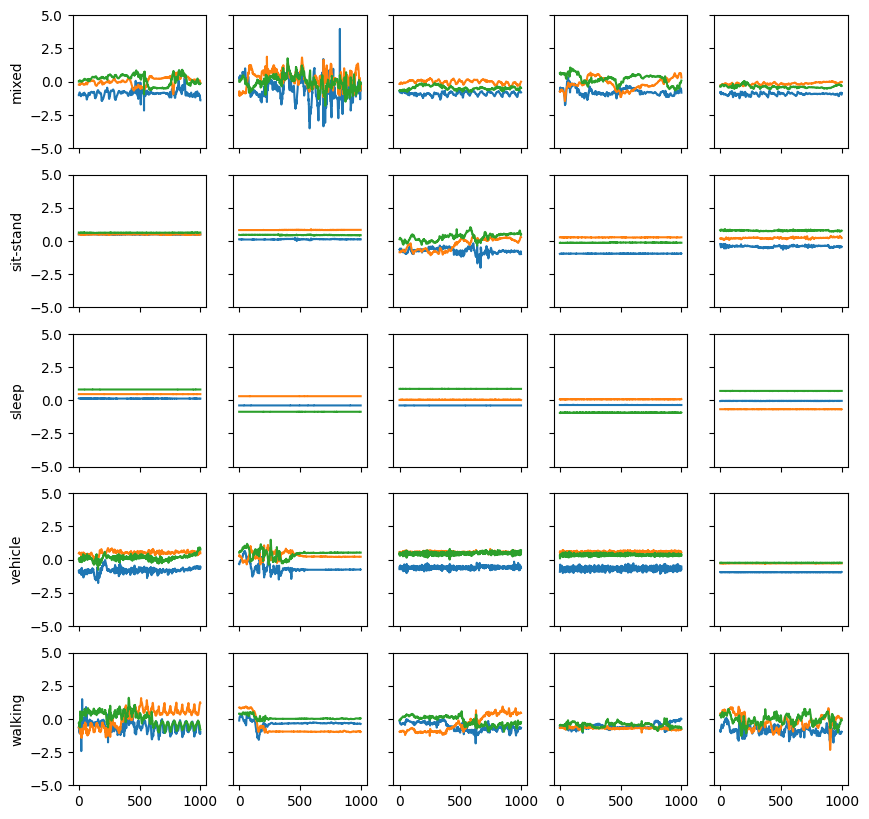

In [12]:
# plotting the activities
plots = 5
unique_labels = np.unique(Y)
fig, ax = plt.subplots(len(unique_labels), plots, sharex = True, sharey = True, figsize = (10, 10))
for label, row in zip(unique_labels, ax):
    i = np.random.choice(np.where(Y == label)[0], size = plots)
    row[0].set_ylabel(label)
    for feature, x in zip(X[i], row):
        x.plot(feature)
        x.set_ylim(-5, 5)
fig.show()

In [13]:
# training model to predict activity
Xf = pd.DataFrame([extract_features(x) for x in X])
Xf

,xmin,xq25,xmed,xq75,xmax,ymin,yq25,ymed,yq75,ymax,...,rollg,pitchg,yawg,pentropy,f1,f2,p1,p2,numPeaks,peakPromin
0,-0.482334,-0.466690,-0.466690,-0.466690,-0.466690,-0.548902,-0.548902,-0.533341,-0.533341,-0.517780,...,-0.684757,-0.619838,-2.289064,0.636767,0.333333,3.666667,0.000003,2.646921e-06,0,0.0
1,-0.482334,-0.466690,-0.466690,-0.466690,-0.466690,-0.548902,-0.548902,-0.533341,-0.533341,-0.517780,...,-0.684402,-0.620273,-2.289879,0.636657,0.333333,1.666667,0.000002,9.033375e-07,0,0.0
2,-0.482334,-0.482334,-0.466690,-0.466690,-0.466690,-0.548902,-0.533341,-0.533341,-0.533341,-0.517780,...,-0.681464,-0.621708,-2.294348,0.636704,0.333333,8.666667,0.000002,1.587059e-06,0,0.0
3,-0.482398,-0.482334,-0.466690,-0.466690,-0.466690,-0.548902,-0.533341,-0.533341,-0.533341,-0.517780,...,-0.681382,-0.621487,-2.294200,0.636693,0.333333,4.666667,0.000001,8.028762e-07,0,0.0
4,-0.482398,-0.482334,-0.466690,-0.466690,-0.466626,-0.548902,-0.533341,-0.533341,-0.533341,-0.517762,...,-0.681401,-0.622920,-2.295682,0.636836,6.000000,0.333333,0.000001,1.274522e-06,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.033708,0.033772,0.049416,0.049416,0.049416,-0.813407,-0.797846,-0.797846,-0.797846,-0.782266,...,-0.956196,0.082110,-1.512754,0.636932,4.666667,9.333333,0.000003,1.696328e-06,0,0.0
7348,0.033708,0.033772,0.049416,0.049416,0.065059,-0.813407,-0.797846,-0.797846,-0.797846,-0.782266,...,-0.954800,0.081032,-1.513337,0.636972,0.333333,4.666667,0.000008,3.498778e-06,0,0.0
7349,0.033772,0.049416,0.049416,0.049416,0.049416,-0.797846,-0.797846,-0.797846,-0.782285,-0.782285,...,-0.951256,0.081168,-1.512803,0.636836,0.333333,4.666667,0.000006,4.144990e-06,0,0.0
7350,0.033708,0.033772,0.049352,0.049416,0.049416,-0.797846,-0.797846,-0.797827,-0.782285,-0.782266,...,-0.950068,0.075769,-1.516530,0.636888,3.666667,0.333333,0.000004,3.898301e-06,0,0.0


In [14]:
# training model
rfc = RandomForestClassifier(
    n_estimators=100,
    n_jobs=4,
    random_state=42
)
rfc.fit(Xf, Y)

RandomForestClassifier(n_jobs=4, random_state=42)

In [15]:
print(classification_report(Y, rfc.predict(Xf), zero_division=0))

              precision    recall  f1-score   support

       mixed       1.00      1.00      1.00      1383
   sit-stand       1.00      1.00      1.00      2081
       sleep       1.00      1.00      1.00      2742
     vehicle       1.00      1.00      1.00       588
     walking       1.00      1.00      1.00       558

    accuracy                           1.00      7352
   macro avg       1.00      1.00      1.00      7352
weighted avg       1.00      1.00      1.00      7352



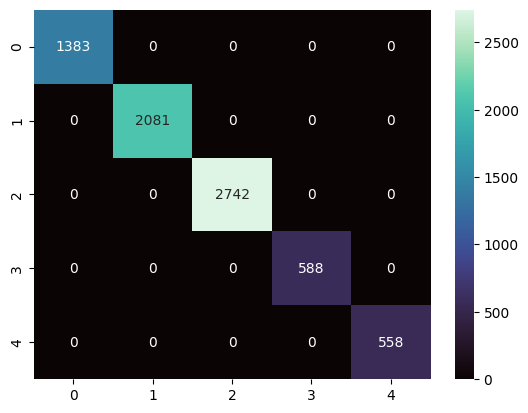

In [16]:
Yp = rfc.predict(Xf)
sns.heatmap(confusion_matrix(Y, Yp), cmap = "mako", annot = True, fmt = "")
plt.show()

In [17]:
# trying to extend model to another person
data = pd.read_csv(
    "data/capture24/P002.csv.gz", compression="gzip",
    index_col="time", parse_dates=["time"],
    dtype={"x": "f4", "y": "f4", "z": "f4", "annotation": "string"}
    )
data["label"] = annot["label:Willetts2018"].reindex(data["annotation"]).to_numpy()
X, Y = window(data)
Xf = pd.DataFrame([extract_features(x) for x in X])
Xf

,xmin,xq25,xmed,xq75,xmax,ymin,yq25,ymed,yq75,ymax,...,rollg,pitchg,yawg,pentropy,f1,f2,p1,p2,numPeaks,peakPromin
0,-0.394386,-0.378620,-0.378620,-0.362854,-0.331323,0.444236,0.459966,0.459966,0.459966,0.475696,...,0.524423,-0.436545,2.249541,0.637346,7.333333,8.666667,9.367362e-06,7.080943e-06,0,0.0
1,-0.410152,-0.378620,-0.378620,-0.378620,-0.347089,0.444236,0.459966,0.459966,0.459966,0.475696,...,0.523789,-0.443915,2.259607,0.637133,8.666667,6.333333,1.046224e-05,6.608698e-06,0,0.0
2,-0.410152,-0.394386,-0.378620,-0.378620,-0.347089,0.444236,0.459966,0.459966,0.459966,0.475696,...,0.524348,-0.448863,2.265220,0.636988,8.666667,6.333333,1.505686e-05,5.948224e-06,0,0.0
3,-0.410152,-0.394386,-0.378620,-0.378620,-0.347089,0.444236,0.459966,0.459966,0.459966,0.475696,...,0.524403,-0.449655,2.266151,0.637113,9.000000,6.333333,7.663330e-06,4.538198e-06,0,0.0
4,-0.410152,-0.394386,-0.378620,-0.378620,-0.347089,0.444236,0.459966,0.459966,0.459966,0.475696,...,0.524651,-0.451199,2.267813,0.637058,7.333333,8.666667,6.331532e-06,4.459301e-06,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5581,-0.360339,-0.344573,-0.344573,-0.344573,-0.328807,-0.732336,-0.716605,-0.700875,-0.700875,-0.700875,...,-0.852760,-0.507375,-2.022894,0.636961,5.333333,9.333333,1.932607e-06,1.836454e-06,0,0.0
5582,-0.344933,-0.344933,-0.344573,-0.344573,-0.328807,-0.717062,-0.701332,-0.700875,-0.700875,-0.685602,...,-0.842238,-0.501242,-2.025544,0.636636,0.333333,1.333333,1.355520e-06,5.833004e-07,0,0.0
5583,-0.344933,-0.344933,-0.344573,-0.344573,-0.328807,-0.717062,-0.701332,-0.701332,-0.700875,-0.685602,...,-0.841281,-0.500465,-2.025575,0.636695,0.333333,5.666667,1.077820e-06,4.969621e-07,0,0.0
5584,-0.344933,-0.344933,-0.344933,-0.344933,-0.329167,-0.717062,-0.701332,-0.701332,-0.701332,-0.685602,...,-0.840856,-0.500473,-2.025919,0.636646,0.333333,34.333333,5.117325e-07,4.330448e-07,0,0.0


In [18]:
# checking metrics
print(classification_report(Y, rfc.predict(Xf), zero_division=0))

              precision    recall  f1-score   support

   bicycling       0.00      0.00      0.00       230
       mixed       0.40      0.77      0.52       724
   sit-stand       0.69      0.52      0.59      2073
       sleep       0.93      0.78      0.85      2160
     vehicle       0.00      0.00      0.00         0
     walking       0.52      0.24      0.33       399

    accuracy                           0.61      5586
   macro avg       0.42      0.39      0.38      5586
weighted avg       0.70      0.61      0.64      5586



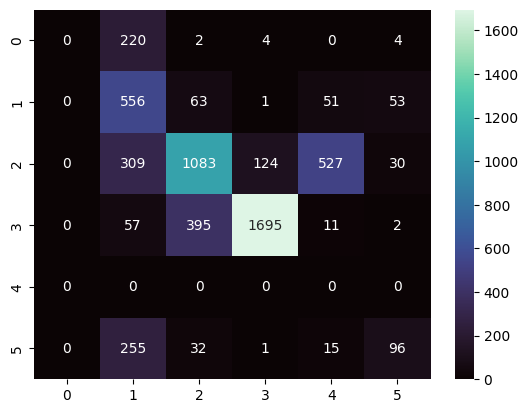

In [19]:
# plotting prediction heatmap
Yp = rfc.predict(Xf)
sns.heatmap(confusion_matrix(Y, Yp), cmap = "mako", annot = True, fmt = "")
plt.show()